In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/crime-data-analysis'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-data-analysis/Crime_Data_from_2020_to_Present.csv
/kaggle/input/crime-data-analysis/crime_data_analysis_report.pdf


In [4]:
# Veri setini yükle
data = pd.read_csv('/kaggle/input/crime-data-analysis/Crime_Data_from_2020_to_Present.csv')


In [5]:
# İlk birkaç satırı görüntüle
print(data.head())

print("*********************************************************************************************")
# Sütunlar hakkında genel bilgi al
print(data.info())
print("*********************************************************************************************")

# Eksik değerlerin durumunu kontrol et
print(data.isnull().sum())


       DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM      2130     7   
1  200106753  02/09/2020 12:00:00 AM  02/08/2020 12:00:00 AM      1800     1   
2  200320258  11/11/2020 12:00:00 AM  11/04/2020 12:00:00 AM      1700     3   
3  200907217  05/10/2023 12:00:00 AM  03/10/2020 12:00:00 AM      2037     9   
4  220614831  08/18/2022 12:00:00 AM  08/17/2020 12:00:00 AM      1200     6   

   AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0   Wilshire          784         1     510   
1    Central          182         1     330   
2  Southwest          356         1     480   
3   Van Nuys          964         1     343   
4  Hollywood          666         2     354   

                                Crm Cd Desc  ... Status   Status Desc  \
0                          VEHICLE - STOLEN  ...     AA  Adult Arrest   
1                     BURGLARY FROM VEHICLE  ...     IC   Invest Cont   
2                

In [6]:
# Sayısal verilerin özet istatistikleri
print(data.describe())

# Kategorik verilerin benzersiz değerlerini kontrol et
for column in data.select_dtypes(include='object').columns:
    print(f"{column}: {data[column].nunique()} unique values")

              DR_NO       TIME OCC           AREA    Rpt Dist No  \
count  9.553390e+05  955339.000000  955339.000000  955339.000000   
mean   2.191355e+08    1338.453032      10.718033    1118.243545   
std    1.261589e+07     652.186527       6.100431     610.098189   
min    8.170000e+02       1.000000       1.000000     101.000000   
25%    2.105125e+08     900.000000       6.000000     621.000000   
50%    2.207106e+08    1420.000000      11.000000    1142.000000   
75%    2.307171e+08    1900.000000      16.000000    1618.000000   
max    2.499187e+08    2359.000000      21.000000    2199.000000   

            Part 1-2         Crm Cd       Vict Age      Premis Cd  \
count  955339.000000  955339.000000  955339.000000  955327.000000   
mean        1.407805     500.667710      29.383110     306.255200   
std         0.491427     206.867837      21.909695     217.844195   
min         1.000000     110.000000      -4.000000     101.000000   
25%         1.000000     331.000000       

 **A. Mocodes**
* Kategorik bir veri olduğu için bu sütunu en sık kullanılan değer (mode) ile doldurabiliriz.

In [7]:
data = data.fillna({'Mocodes': data['Mocodes'].mode()[0]})


 **B. Vict Sex ve Vict Descent**
* Bu sütunlarda cinsiyet ve etnik köken bilgisi bulunuyor. Bu değerleri de en sık kullanılan değerle dolduruyoruz.

In [8]:
data = data.fillna({
    'Vict Sex': data['Vict Sex'].mode()[0],
    'Vict Descent': data['Vict Descent'].mode()[0]
})

 **C. Weapon Used Cd ve Weapon Desc**
* Silah kullanılan olaylar için çok fazla eksik veri var. Burada olayın doğasına göre belirsiz durumları 'Silah Kullanılmadı' (No Weapon) gibi bir kategori ile doldurmak iyi bir çözüm olabilir.

In [9]:
data = data.fillna({
    'Weapon Used Cd': 0,
    'Weapon Desc': 'No Weapon'
})


**D. Premis Cd ve Premis Desc**
* Premis Cd genellikle olayın gerçekleştiği mekan kodunu temsil eder. Bu yüzden en sık kullanılan değerle doldurabiliriz.

In [10]:
data = data.fillna({
    'Premis Cd': data['Premis Cd'].mode()[0],
    'Premis Desc': data['Premis Desc'].mode()[0]
})


**E. Crm Cd 2, Crm Cd 3, Crm Cd 4**
* Bu kodlar, olayla ilişkili ek suç kodlarını temsil eder. Bu yüzden eksik olanları sıfır (0) ile doldurabiliriz, çünkü ek bir suç kodu yok anlamına gelir

In [11]:
data = data.fillna({
    'Crm Cd 1': 0,
    'Crm Cd 2': 0,
    'Crm Cd 3': 0,
    'Crm Cd 4': 0
})


**F. Cross Street**
* Birçok olayda çapraz sokak verisi eksik olabilir. Bunu No Cross Street olarak doldurabiliriz.

In [12]:
data = data.fillna({
    'Cross Street': 'No Cross Street'
})


**G. Eksik verileri kontrol etme**

In [13]:
from sklearn.impute import SimpleImputer

# Eksik değerleri en yaygın değerle doldurun
imputer = SimpleImputer(strategy='most_frequent')

# fit_transform yalnızca bir sütunla çalışırken sorun çıkabilir. Bu nedenle sütunu bir DataFrame'e dönüştürmelisiniz.
status_column = data[['Status']]
data['Status'] = imputer.fit_transform(status_column).ravel()


In [14]:
print(data.isnull().sum())


DR_NO             0
Date Rptd         0
DATE OCC          0
TIME OCC          0
AREA              0
AREA NAME         0
Rpt Dist No       0
Part 1-2          0
Crm Cd            0
Crm Cd Desc       0
Mocodes           0
Vict Age          0
Vict Sex          0
Vict Descent      0
Premis Cd         0
Premis Desc       0
Weapon Used Cd    0
Weapon Desc       0
Status            0
Status Desc       0
Crm Cd 1          0
Crm Cd 2          0
Crm Cd 3          0
Crm Cd 4          0
LOCATION          0
Cross Street      0
LAT               0
LON               0
dtype: int64


**Verilerin Özet İstatistikleri**

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

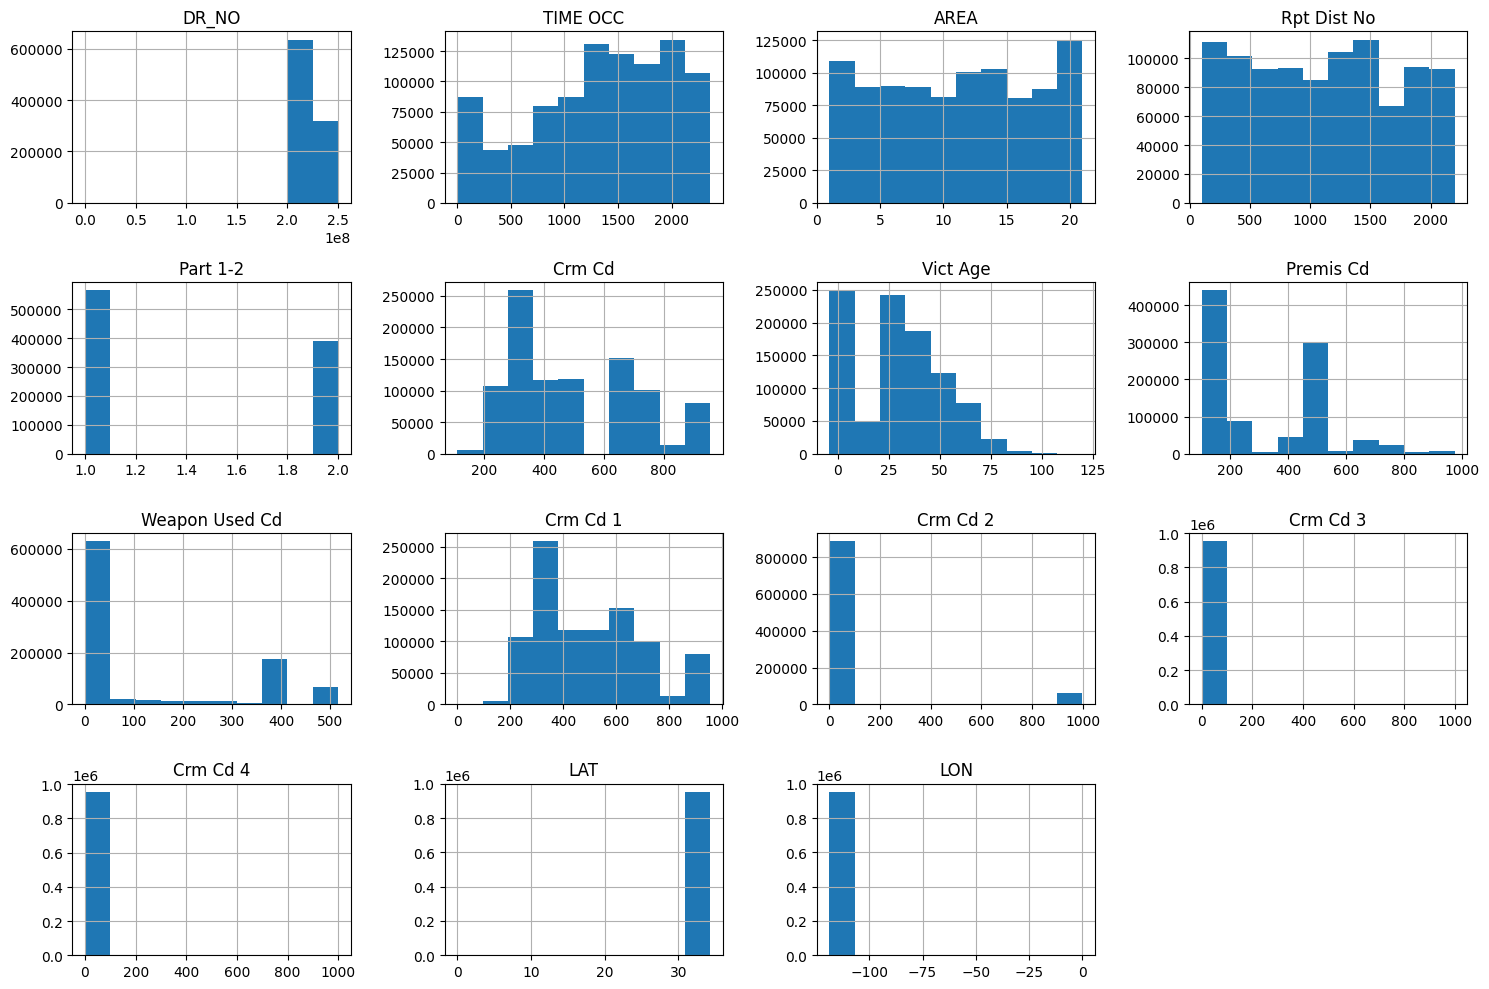

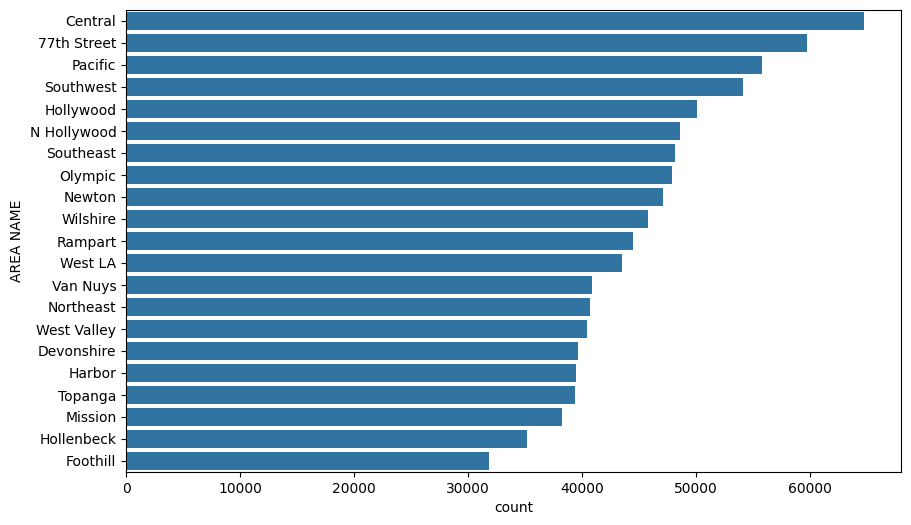

In [16]:

# Sayısal değişkenlerin dağılımı
data.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

# Kategorik değişkenlerin dağılımı (örneğin AREA NAME)
plt.figure(figsize=(10, 6))
sns.countplot(y=data['AREA NAME'], order=data['AREA NAME'].value_counts().index)
plt.show()


**Korelasyon Analizi**

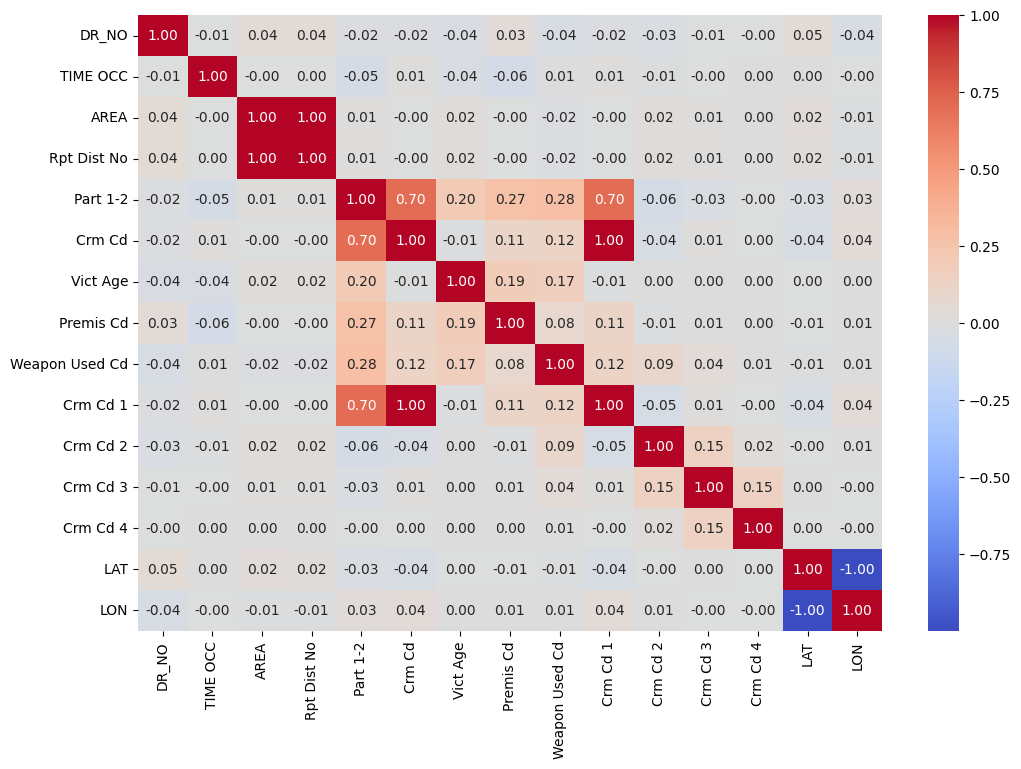

In [17]:
# Yalnızca sayısal sütunları seç
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Korelasyon matrisini oluştur
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


**Zaman Serisi Analizi**

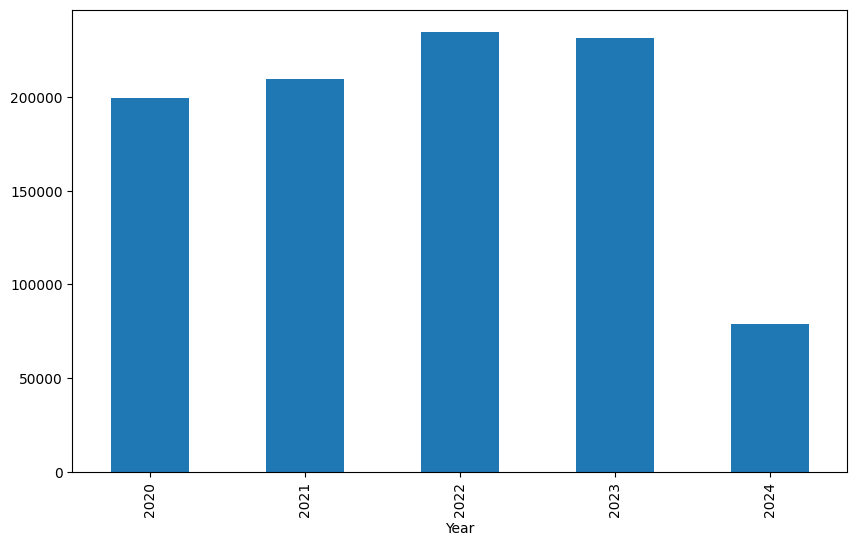

In [18]:
# Tarih formatını açıkça belirterek dönüştür
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')

# Yıl sütununu oluştur
data['Year'] = data['DATE OCC'].dt.year

# Yıllara göre suç dağılımı
plt.figure(figsize=(10, 6))
data['Year'].value_counts().sort_index().plot(kind='bar')
plt.show()


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [20]:
# Kategorik sütunları tanımlama
categorical_columns = data.select_dtypes(include=['object']).columns
print("Kategorik sütunlar:", categorical_columns)

Kategorik sütunlar: Index(['Date Rptd', 'AREA NAME', 'Crm Cd Desc', 'Mocodes', 'Vict Sex',
       'Vict Descent', 'Premis Desc', 'Weapon Desc', 'Status', 'Status Desc',
       'LOCATION', 'Cross Street'],
      dtype='object')


**Veri İşleme**

In [21]:
import pandas as pd
import numpy as np
import gc
from joblib import Parallel, delayed

# Parça boyutunu belirleyin
chunksize = 5000  # Daha küçük bir parça boyutu
data_chunks = pd.read_csv('/kaggle/input/crime-data-analysis/Crime_Data_from_2020_to_Present.csv', chunksize=chunksize)

def process_chunk(chunk, columns, threshold=0.05):
    """Nadir kategorileri birleştirir ve eksik değerleri doldurur."""
    # Tarih sütununu işleyin
    chunk['Date Rptd'] = pd.to_datetime(chunk['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p')

    # Kategorik sütunları dönüştürün
    for column in columns:
        value_counts = chunk[column].value_counts(normalize=True)
        rare_categories = value_counts[value_counts < threshold].index
        chunk[column] = chunk[column].replace(rare_categories, 'Other')

    return chunk

def convert_categoricals(df, columns):
    """Kategorik sütunları daha verimli hale getirir."""
    for column in columns:
        df[column] = pd.Categorical(df[column])
    return df

def process_and_append(chunk):
    """Her bir parçayı işler ve kategorik sütunları dönüştürür."""
    categorical_columns = chunk.select_dtypes(include=['object']).columns
    chunk = convert_categoricals(chunk, categorical_columns)
    processed_chunk = process_chunk(chunk, categorical_columns)
    return processed_chunk

# İşlenmiş parçaları saklamak için bir liste
processed_chunks = []

# Parçaları işleyin ve bellek kullanımını optimize edin
for chunk in data_chunks:
    processed_chunk = process_and_append(chunk)
    processed_chunks.append(processed_chunk)
    del chunk  # İşlemden sonra parçayı bellekten temizle
    gc.collect()  # Çöp toplama işlemi başlat

# Tüm parçaları birleştirin
data = pd.concat(processed_chunks, ignore_index=True)

In [22]:
# Tarih sütununu kontrol edin ve dönüştürün
data['Date Rptd'] = pd.to_datetime(data['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Tarih sütununu ayırın
if pd.api.types.is_datetime64_any_dtype(data['Date Rptd']):
    data['Year_Rptd'] = data['Date Rptd'].dt.year
    data['Month_Rptd'] = data['Date Rptd'].dt.month
    data['Day_Rptd'] = data['Date Rptd'].dt.day
else:
    print("Date Rptd sütunu datetime formatında değil!")

# Sayısal verileri daha verimli bir türde saklayın
for column in data.select_dtypes(include=['int64']).columns:
    data[column] = data[column].astype('int32')

for column in data.select_dtypes(include=['float64']).columns:
    data[column] = data[column].astype('float32')

print(data.info())  # Veri setinin bilgilerini kontrol edin

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955339 entries, 0 to 955338
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DR_NO           955339 non-null  int32         
 1   Date Rptd       0 non-null       datetime64[ns]
 2   DATE OCC        955339 non-null  category      
 3   TIME OCC        955339 non-null  int32         
 4   AREA            955339 non-null  int32         
 5   AREA NAME       955339 non-null  object        
 6   Rpt Dist No     955339 non-null  int32         
 7   Part 1-2        955339 non-null  int32         
 8   Crm Cd          955339 non-null  int32         
 9   Crm Cd Desc     955339 non-null  object        
 10  Mocodes         818664 non-null  object        
 11  Vict Age        955339 non-null  int32         
 12  Vict Sex        825294 non-null  object        
 13  Vict Descent    825284 non-null  category      
 14  Premis Cd       955327 non-null  flo

In [23]:
X = data.drop(columns=['DR_NO', 'Date Rptd', 'DATE OCC', 'Vict Age', 'Crm Cd Desc'])  # Özellikler
y = data['Crm Cd Desc']  # Hedef değişken

# Kategorik verileri sayısal hale getirin
X = pd.get_dummies(X, drop_first=True)

# Eğitim ve test setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Özellikleri standartlaştırın
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [25]:
from sklearn.impute import SimpleImputer

# Eksik değerleri doldurmak için SimpleImputer kullanın
imputer = SimpleImputer(strategy='most_frequent')  # En yayzzgın değer ile doldur
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Ayrıca, hedef değişkenin eksik değerlerini kontrol edin ve doldurun
y_train = y_train.fillna(y_train.mode()[0])  # En yaygın değer ile doldur
y_test = y_test.fillna(y_test.mode()[0])  # En yaygın değer ile doldur


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [13 14 15]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [13 14 15]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


**Gözetimli Modeller**

**Regression**

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Modeli oluşturun
model = LogisticRegression()

# Modeli eğitin
model.fit(X_train, y_train)

# Tahminlerde bulunun
y_pred = model.predict(X_test)

# Model performansını değerlendirin
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7109720099650386


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                                                           precision    recall  f1-score   support

          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.59      0.54      0.56      9853
                                BATTERY - SIMPLE ASSAULT       0.66      0.88      0.75     14980
                                                BURGLARY       0.71      0.76      0.73     11434
                                   BURGLARY FROM VEHICLE       0.57      0.52      0.55     11804
                       INTIMATE PARTNER - SIMPLE ASSAULT       0.35      0.09      0.14      4438
                                                   Other       0.70      0.76      0.73     88195
                SHOPLIFTING - PETTY THEFT ($950 & UNDER)       0.34      0.02      0.05      1009
         THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       0.00      0.00      0.00      1136
                                       THEFT OF IDENTITY       0.79      0.99      0.88      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Modeli oluşturun
decision_tree = DecisionTreeClassifier(random_state=42)

# Modeli eğitin
decision_tree.fit(X_train, y_train)

# Tahminlerde bulunun
y_pred_tree = decision_tree.predict(X_test)

# Model performansını değerlendirin
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.908200221910524
Decision Tree Classification Report:
                                                           precision    recall  f1-score   support

          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.94      0.92      0.93      9853
                                BATTERY - SIMPLE ASSAULT       1.00      1.00      1.00     14980
                                                BURGLARY       0.99      0.98      0.99     11434
                                   BURGLARY FROM VEHICLE       1.00      1.00      1.00     11804
                       INTIMATE PARTNER - SIMPLE ASSAULT       0.51      0.51      0.51      4438
                                                   Other       0.90      0.90      0.90     88195
                SHOPLIFTING - PETTY THEFT ($950 & UNDER)       0.42      0.43      0.43      1009
         THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       0.17      0.19      0.18      1136
                                     

**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB


# Modeli oluşturun
naive_bayes_model = GaussianNB()

# Modeli eğitin
naive_bayes_model.fit(X_train, y_train)

# Tahminlerde bulunun
y_pred_nb = naive_bayes_model.predict(X_test)

# Model performansını değerlendirin
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8582441853162225
Naive Bayes Classification Report:
                                                           precision    recall  f1-score   support

          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.93      0.99      0.96      9853
                                BATTERY - SIMPLE ASSAULT       1.00      0.98      0.99     14980
                                                BURGLARY       0.99      0.98      0.98     11434
                                   BURGLARY FROM VEHICLE       1.00      0.98      0.99     11804
                       INTIMATE PARTNER - SIMPLE ASSAULT       0.48      0.98      0.65      4438
                                                   Other       0.98      0.71      0.82     88195
                SHOPLIFTING - PETTY THEFT ($950 & UNDER)       0.20      1.00      0.33      1009
         THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       0.15      0.98      0.26      1136
                                       T

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Modeli oluşturun
random_forest = RandomForestClassifier(random_state=42)

# Modeli eğitin
random_forest.fit(X_train, y_train)

# Tahminlerde bulunun
y_pred_forest = random_forest.predict(X_test)

# Model performansını değerlendirin
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_forest))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_forest))


Random Forest Accuracy: 0.926209517030586


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Classification Report:
                                                           precision    recall  f1-score   support

          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.93      1.00      0.96      9853
                                BATTERY - SIMPLE ASSAULT       1.00      1.00      1.00     14980
                                                BURGLARY       0.99      1.00      0.99     11434
                                   BURGLARY FROM VEHICLE       1.00      1.00      1.00     11804
                       INTIMATE PARTNER - SIMPLE ASSAULT       0.52      0.48      0.50      4438
                                                   Other       0.93      0.91      0.92     88195
                SHOPLIFTING - PETTY THEFT ($950 & UNDER)       0.50      0.41      0.45      1009
         THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       0.15      0.02      0.04      1136
                                       THEFT OF IDENTITY       0.81      0.94  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**K-Nearest Neighbors (KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Modeli oluşturun
knn_model = KNeighborsClassifier()

# Modeli eğitin
knn_model.fit(X_train, y_train)

# Tahminlerde bulunun
y_pred_knn = knn_model.predict(X_test)

# Model performansını değerlendirin
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.7349477672870391


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN Classification Report:
                                                           precision    recall  f1-score   support

          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.63      0.68      0.65      9853
                                BATTERY - SIMPLE ASSAULT       0.65      0.82      0.72     14980
                                                BURGLARY       0.74      0.81      0.77     11434
                                   BURGLARY FROM VEHICLE       0.58      0.61      0.60     11804
                       INTIMATE PARTNER - SIMPLE ASSAULT       0.32      0.25      0.28      4438
                                                   Other       0.76      0.71      0.74     88195
                SHOPLIFTING - PETTY THEFT ($950 & UNDER)       0.45      0.23      0.31      1009
         THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       0.16      0.03      0.05      1136
                                       THEFT OF IDENTITY       0.80      0.91      0.85  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Modeli oluşturun
gb_model = GradientBoostingClassifier(random_state=42)

# Modeli eğitin
gb_model.fit(X_train, y_train)

# Tahminlerde bulunun
y_pred_gb = gb_model.predict(X_test)

# Model performansını değerlendirin
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.9315688655347835
Gradient Boosting Classification Report:
                                                           precision    recall  f1-score   support

          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.93      1.00      0.96      9853
                                BATTERY - SIMPLE ASSAULT       1.00      1.00      1.00     14980
                                                BURGLARY       0.99      1.00      0.99     11434
                                   BURGLARY FROM VEHICLE       1.00      1.00      1.00     11804
                       INTIMATE PARTNER - SIMPLE ASSAULT       0.54      0.33      0.41      4438
                                                   Other       0.94      0.91      0.92     88195
                SHOPLIFTING - PETTY THEFT ($950 & UNDER)       0.88      0.08      0.15      1009
         THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       1.00      0.00      0.00      1136
                            

**Gözetimsiz Modeller**

**K-Means Kümeleme**

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [13 14 15]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [13 14 15]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


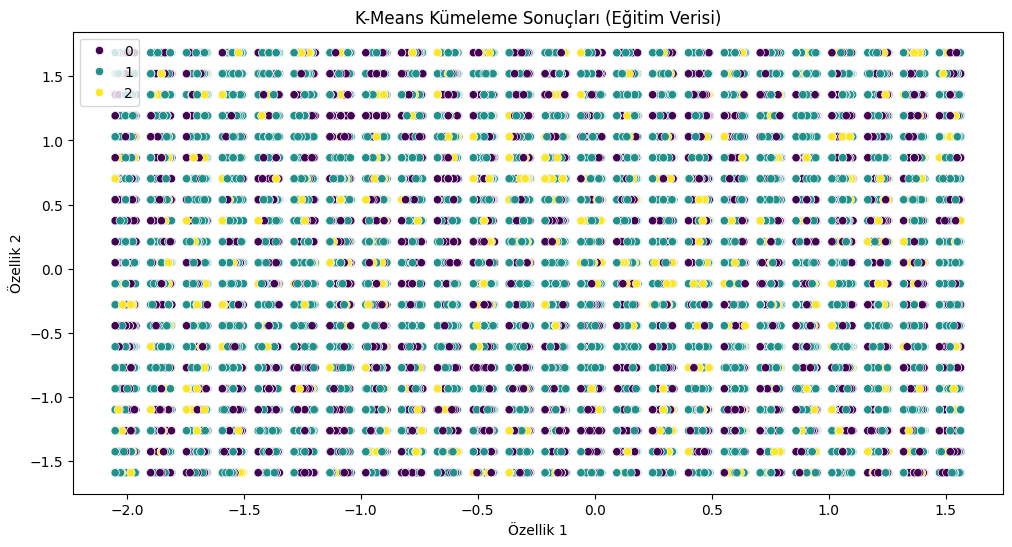

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


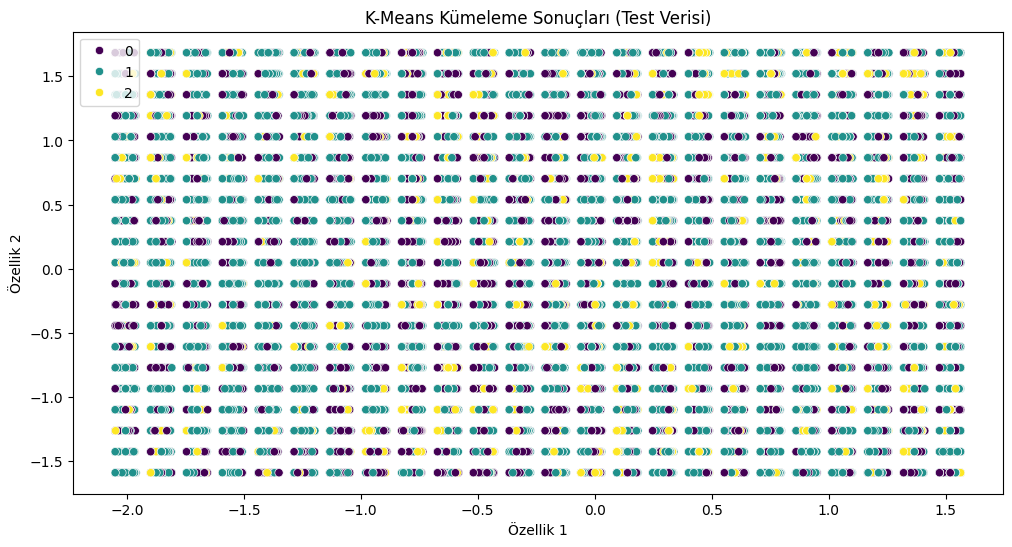

In [70]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Eksik değerleri doldurmak için SimpleImputer kullanın
imputer = SimpleImputer(strategy='mean')  # Ortalamayı kullanarak doldur
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Veriyi ölçeklendirin
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# K-Means Kümeleme
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)
clusters_train = kmeans.predict(X_train_scaled)
clusters_test = kmeans.predict(X_test_scaled)

# Kümeleme sonuçlarını görselleştirin (Eğitim verisi)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_train_scaled[:, 0], y=X_train_scaled[:, 1], hue=clusters_train, palette='viridis')
plt.title('K-Means Kümeleme Sonuçları (Eğitim Verisi)')
plt.xlabel('Özellik 1')
plt.ylabel('Özellik 2')
plt.show()

# Kümeleme sonuçlarını görselleştirin (Test verisi)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_test_scaled[:, 0], y=X_test_scaled[:, 1], hue=clusters_test, palette='viridis')
plt.title('K-Means Kümeleme Sonuçları (Test Verisi)')
plt.xlabel('Özellik 1')
plt.ylabel('Özellik 2')
plt.show()


In [28]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.5 MB/s eta 0:00:00


**HDBSCAN**

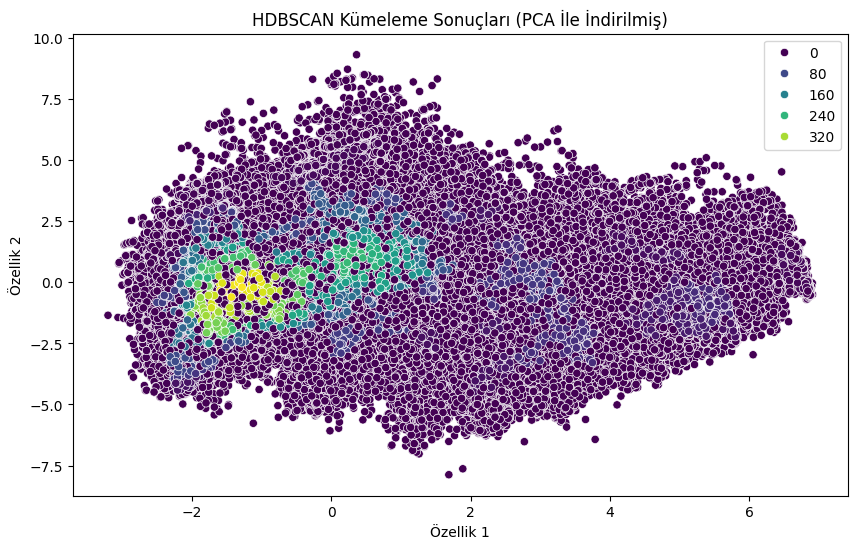

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Eksik değerleri doldurmak için SimpleImputer kullanın
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Veriyi ölçeklendirin
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Veri boyutunu küçültme (PCA kullanarak)
pca = PCA(n_components=2)  # İki bileşen
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# HDBSCAN kümeleme
hdb = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500)
clusters_hdbscan = hdb.fit_predict(X_train_pca)

# Kümeleme sonuçlarını görselleştirin
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=clusters_hdbscan, palette='viridis')
plt.title('HDBSCAN Kümeleme Sonuçları (PCA İle İndirilmiş)')
plt.xlabel('Özellik 1')
plt.ylabel('Özellik 2')
plt.show()


**MiniBatch KMeans**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


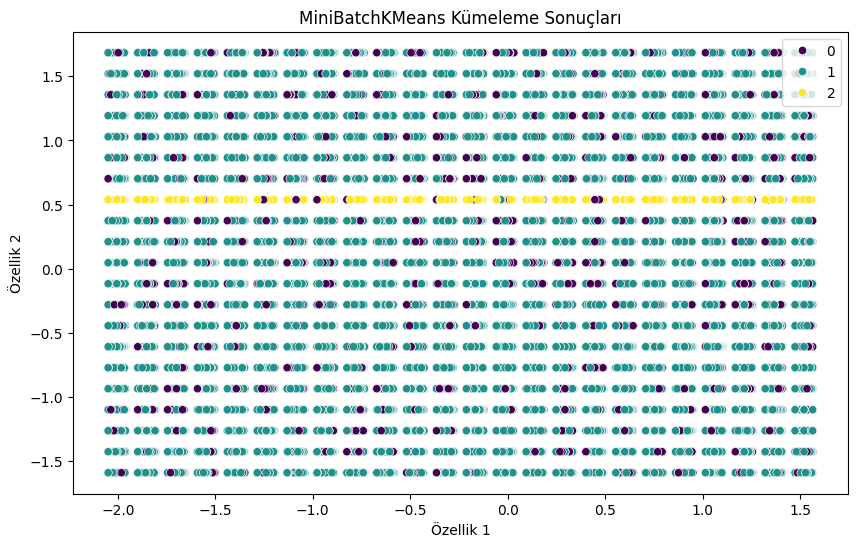

In [26]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

# MiniBatchKMeans modeli oluştur
mini_kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=500)

# Eğitim verisinde modeli uygula
mini_kmeans.fit(X_train)

# Küme tahminlerini al
clusters_train = mini_kmeans.predict(X_train)
clusters_test = mini_kmeans.predict(X_test)

# t-SNE sonuçlarını görselleştir
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=clusters_train, palette='viridis')
plt.title('MiniBatchKMeans Kümeleme Sonuçları')
plt.xlabel('Özellik 1')
plt.ylabel('Özellik 2')
plt.show()
